# Images Classification.

* [Data](#Data)
* [Pipeline](#Pipeline)
* [Setting Model](#Model-definition)
* [Training](#Training)
* [Validation](#Validation)
* [AlexNet](#AlexNet)
* [VGG](#VGG)
* [ResNet](#ResNet)

In [ ]:
import sys

import PIL
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('..')

## Data

In [ ]:
from batchflow.opensets import Imagenette160# CIFAR10, CIFAR100, ImageWoof, PascalClassification, MNIST

Load dataset.

In [ ]:
data = Imagenette160()

Thats what happening under the hood the line above.

In [ ]:
# from batchflow import DatasetIndex, Dataset, ImagesBatch
#
# my_index = DatasetIndex(np.arange(len(imagenette_data)))
#
# data = Dataset(my_index, 
#                batch_class=ImagesBatch, 
#                preloaded=imagenette_data)

Dataset divided into train and test parts.

In [ ]:
print('Images in train: {}'.format(len(data.train)))
print('Images in test: {}'.format(len(data.test)))

Plot some images from the dataset.

In [ ]:
from utils import plot_images

In [ ]:
classes = ['tench', 'English springer', 'cassette player', 'chain saw', 'church',
           'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']

In [ ]:
ind = np.random.randint(len(data.train), size=10)

images = data.train.images[ind]
labels = data.train.labels[ind]
images = np.array(images)
plot_images(images, labels=labels, classes=classes, figsize=(15, 15))

## Pipeline

Declare pipeline with augmentations.   

In [ ]:
pipeline = (data.train.pipeline()
               .crop(shape=(160, 160), origin='random', src='images', dst='augm_images')
               .flip(p=0.5, src='augm_images', dst='augm_images')
           )

Take a look the all images actions avaliable. [link](https://github.com/analysiscenter/batchflow/blob/master/examples/tutorials/06_image_augmentation.ipynb)

In [ ]:
# class ImagesBatch:
#     def crop(self):
#         # code for cropping images
#         return self
    
#     def flip(self):
#         # code for flipping images
#         return self

Generate the batch and pass it through the pipeline.

In [ ]:
batch = pipeline.next_batch(batch_size=5, shuffle=True)

In [ ]:
for i in range(len(batch)):
    fig, ax = plt.subplots(1, 2 , figsize=(10, 3))
    ax[0].imshow(batch.images[i])
    ax[1].imshow(batch.augm_images[i])

# Model

In [ ]:
from batchflow.models.torch import TorchModel
from batchflow import B, V, W

Configure the model.

In [ ]:
model_config = {
#          'initial_block': empty
           'body': {'layout': 'ca ca', 'filters': [3, 3], 'kernel_size': 3},
           'head': {'layout': 'f', 'units': 10},
    
           'output': {'predicted': ['proba']},    
           'loss': 'ce',
           'optimizer': dict(name='SGD', lr=0.01),
           'device': 'gpu'
}

# Training

In [ ]:
BATCH_SIZE = 64
N_ITERS = 300

Set the training pipeline.

In [ ]:
train_pipeline = (data.train.p 
                    .crop(shape=(160, 160), origin='random')
                    .flip(p=0.5)
                    .to_array(channels='first') 
                    .init_variable('loss', []) 
                    .init_model('dynamic', TorchModel, 'classification', model_config)
                    .train_model('classification', B('images'), B('labels'), 
                                 fetches='loss', save_to=V('loss', mode='a'))
                    .run_later(BATCH_SIZE, n_iters=N_ITERS, drop_last=True, shuffle=42, bar=True)
                )

In [ ]:
train_pipeline.run(bar_desc=W(V('loss')[-1].format('Loss is: {:7.7}')))

Plot the training loss.

In [ ]:
loss = train_pipeline.v('loss')
plt.figure(figsize=(6, 6))
plt.plot(loss[5:])
plt.grid()

# Validation

Pipeline for model evaluation.

In [ ]:
test_pipeline = (data.test.p
                    .crop(shape=(160, 160), origin='random')
                    .to_array(channels='first')
                    .import_model('classification', train_pipeline)
                    .predict_model('classification', B('images'), fetches='predicted_proba', 
                                   save_to=B('predictions'))
                    .init_variable('metrics')
                    .gather_metrics('class', targets=B.labels, predictions=B.predictions,
                                    fmt='proba', axis=-1, save_to=V('metrics'))
                    .run_later(250, shuffle=True, n_epochs=1, drop_last=True, bar=True)
                )

In [ ]:
test_pipeline.run()

In [ ]:
metrics = test_pipeline.v('metrics')
accuracy = metrics.evaluate('accuracy')
print('Accuracy {}'.format(accuracy))

Draw images from test data and model predictions

In [ ]:
batch = test_pipeline.next_batch(10, shuffle=True)

images = np.moveaxis(batch.images, 1, -1)
plot_images(images, labels=batch.labels, proba=batch.predictions, figsize=(15, 15))

In [ ]:
batch.predictions

### Config for Pipeline

In [ ]:
from batchflow import C

Reusable pipelines. Can be used many times with different models.   
Its components(models configuration, training scheme) defined through the config.

In [ ]:
train_pipeline = (data.train.p 
                    .crop(shape=(160, 160), origin='random')
                    .flip(p=0.5)
                    .to_array(channels='first') 
                    .init_variable('loss', []) 
                    .init_model('dynamic', C('model_class'), 'classification', C('model'))
                    .train_model('classification', B('images'), B('labels'), 
                                 fetches='loss', save_to=V('loss', mode='a'))
                    .run_later(C('batch_size'), n_iters=C('n_iters'), drop_last=True, shuffle=42, bar=True)
                )

test_pipeline = (data.test.p
                    .crop(shape=(160, 160), origin='random')
                    .to_array(channels='first')
                    .init_variable('metrics')
                    .import_model('classification', C('train_ppl'))
                    .predict_model('classification', B('images'), fetches='predicted_proba', 
                                   save_to=B('predictions'))
                    .gather_metrics('class', targets=B.labels, predictions=B.predictions,
                                    fmt='proba', axis=-1, save_to=V('metrics'))
                    .run_later(300, shuffle=True, n_epochs=1, drop_last=False, bar=True)
                )

# AlexNet 

![AlexNet](https://miro.medium.com/max/2812/1*bD_DMBtKwveuzIkQTwjKQQ.png)

In [ ]:
alexnet_model = {
    'initial_block': {'layout': 'cap', 'kernel_size': 11, 'filters': 4, 'strides': 4},
    
    'body': {'layout': 'cap ca ca cap', 
             'kernel_size': [5, 3, 3, 3], 
             'filters': [8, 16, 32, 64]},
    
    'head': {'layout': 'fa f', 'units': [100, 10]},
       
    'output': {'predicted': ['proba']},    
    'loss': 'ce',
    'optimizer': dict(name='SGD', lr=0.1), 
    'device': 'gpu'
}

In [ ]:
train_config = {
        'model': alexnet_model,
        'model_class': TorchModel,
        'batch_size': 64,
        'n_iters': 300
            }

In [ ]:
alexnet_train = train_pipeline << train_config

In [ ]:
alexnet_train.run(bar_desc=W(V('loss')[-1].format('Loss is: {:7.7}')))

In [ ]:
loss = alexnet_train.v('loss')
plt.plot(loss[10:])

In [ ]:
test_config = {
    'train_ppl': alexnet_train,
}

alexnet_test = test_pipeline << test_config

In [ ]:
alexnet_test.run()

In [ ]:
metrics = alexnet_test.v('metrics')
accuracy = metrics.evaluate('accuracy')
print('Accuracy AlexNet - {}'.format(accuracy))

In [ ]:
model = alexnet_train.m('classification').model
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Total number of params in AlexNet -', num_params)

# VGG

In [ ]:
model_common = {
    'device': 'gpu',
    'loss': 'ce',
    'output': {'predicted': ['proba']},    
}

![VGG](https://neurohive.io/wp-content/uploads/2018/11/vgg16-neural-network-1-e1542973058418.jpg)

In [ ]:
# vgg_model = {
#     'body': dict(layout='cacap' * 2 + 'cacacap' * 3, kernel_size=3, 
#                  filters=[32, 32, 64, 64, 64, 64,  128, 128, 256, 256]),
#     'head': dict(layout='d fa f', units=[100, 10], dropout_rate=0.99), 
    
#     'optimizer': dict(name='Adam', lr=0.001),    
#     **model_common
# }

In [ ]:
from batchflow.models.torch import Encoder
from batchflow.models.torch import VGGBlock

### Dropout layer

![Dropout](http://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/04/1IrdJ5PghD9YoOyVAQ73MJw.gif)

In [ ]:
vgg_model = {
    'body/encoder/num_stages': 5,
    'body/encoder/blocks': dict(base=VGGBlock, layout='ca',
                                filters=[32, 64, 64, 128, 256],
                                depth3=[2, 2, 2, 2, 2]),
    
    'head': dict(layout='fad f', units=[100, 10], dropout_rate=0.99),
    
    'optimizer': dict(name='Adam', lr=0.001),    
    **model_common
}

In [ ]:
train_config = {
        'model': vgg_model,
        'model_class': Encoder,
        'batch_size': 64,
        'n_iters': 500
            }

In [ ]:
vgg_train = train_pipeline << train_config

In [ ]:
vgg_train.run(bar_desc=W(V('loss')[-1].format('Loss is: {:7.7}')))

In [ ]:
loss = vgg_train.v('loss')
plt.plot(loss[10:])

In [ ]:
test_config = {
    'train_ppl': vgg_train,
}

In [ ]:
vgg_test = test_pipeline << test_config

In [ ]:
vgg_test.run()

In [ ]:
metrics = vgg_test.v('metrics')
accuracy = metrics.evaluate('accuracy')
print('Accuracy VGG11 - {}'.format(accuracy))

In [ ]:
model = vgg_train.m('classification').model
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Total number of params in VGG11 -', num_params)

In [ ]:
batch = vgg_test.next_batch(5, shuffle=True)

images = np.moveaxis(batch.images, 1, -1)
plot_images(images, labels=batch.labels, proba=batch.predictions, classes=classes, figsize=(15, 15))

# ResNet

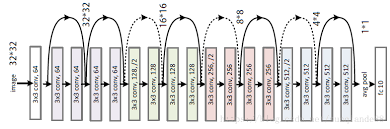

In [ ]:
# resnet_config = {
#            'initial_block':dict(layout='cnap', filters=8, kernel_size=7, strides=2,
#                                 pool_size=3, pool_strides=2),

#            'body': {'layout': 'R cnacna+ R cnacna+ p' * 4,
#                     'filters': [64, 64, 64, 64, 128, 128, 128, 128, 256, 256, 256, 256, 512, 512, 512, 512]},

#            'head': dict(layout='d fa f', units=[100, 10]),
#         }

In [ ]:
# resnet_config = {
#            'initial_block':dict(layout='cnap', filters=8, kernel_size=7, strides=2,
#                                 pool_size=3, pool_strides=2),  

#            'body/encoder/num_stages': 4,
#            'body/encoder/blocks': dict(base=ResBlock, layout='cnacna',
#                                               filters=[8, 16, 32, 64],
#                                               n_reps=[2, 2, 2, 2],
#                                               downsample=[False, True, True, True]),
#
#            head': dict(layout='d fa f', units=[100, 10]),
#         }

Too much!

User ready model from [model's zoo](https://analysiscenter.github.io/batchflow/api/batchflow.models.html).

In [ ]:
from batchflow.models.torch import ResNet18

In [ ]:
resnet_config = {
           'head': dict(layout='fna f', units=[100, 10]),  # dict(layout='cV', filters=10)
           'optimizer': dict(name='Adam', lr=0.001),
            **model_common
        }

In [ ]:
train_config = {
        'model': resnet_config,
        'model_class': ResNet18,
        'batch_size': 64,
        'n_iters': 1000
            }

In [ ]:
resnet_train = train_pipeline << train_config

In [ ]:
resnet_train.run(bar_desc=W(V('loss')[-1].format('Loss is: {:7.7}')))

In [ ]:
loss = resnet_train.v('loss')
plt.plot(loss[10:])

In [ ]:
test_config = {
    'train_ppl': resnet_train
}

resnet_test = test_pipeline << test_config

In [ ]:
resnet_test.run()

In [ ]:
metrics = resnet_test.v('metrics')
accuracy = metrics.evaluate('accuracy')
print('Accuracy ResNet - {}'.format(accuracy))

In [ ]:
model = resnet_train.m('classification').model
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Total number of params in ResNet18 -', num_params)

In [ ]:
batch = resnet_test.next_batch(10, shuffle=True)

images = np.moveaxis(batch.images, 1, -1)
plot_images(images, labels=batch.labels, proba=batch.predictions, classes=classes, figsize=(15, 15))